# Машинное обучение 1, ПМИ ФКН ВШЭ
## Семинар 6
## Калибровка вероятностей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

В этом задании мы будем использовать [данные](https://www.kaggle.com/mssmartypants/rice-type-classification) о бинарной классификации риса.

In [4]:
data = pd.read_csv('data/riceClassification.csv')
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Отмасштабируем данные и разделим на обучение и тест.

In [5]:
X = data.drop(columns=['id', 'Class'])
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=999)
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Посмотрим на баланс классов в данных.

In [6]:
print('Class balance:', y.mean())

Class balance: 0.5490789111905416


Классы можно назвать сбалансированными. Обучим метод опорных векторов (SVC &mdash; Support Vector Classification) и логистическую регрессию, в качестве метрики возьмем ROC-AUC. В качестве скоров будем рассматривать выход `decision_function`, который пропорционален расстоянию до разделяющей гиперплоскости, взятого со знаком.

In [7]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.9991458548930181


In [8]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.9990037517667494


ROC-AUC показывает, что мы практически идеально предсказываем целевую переменную. Посмотрим теперь на распределение скоров для тестовых объектов.

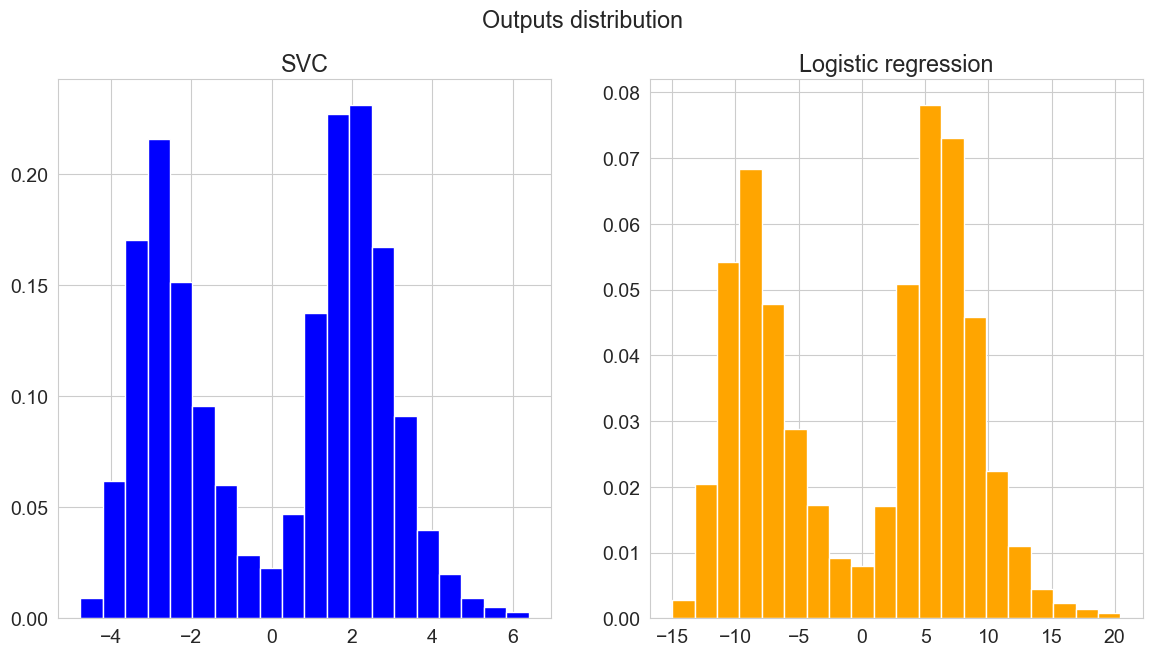

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

Мы видим, что скоры могут принимать любые вещественные значения. Но для оценивания вероятностей нам нужно загнать их в промежуток $[0, 1]$. Для логистической регрессии мы можем навесить сигмоиду, ведь модель и обучалась так, чтобы значение $\sigma\big(\langle w, x \rangle + b\big)$ приближало вероятности. Для SVC у нас нет такой опции, поэтому воспользуемся масштабированием через минимум-максимум.

In [10]:
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr_pred = lr.predict_proba(X_test)[:, 1]

Теперь мы можем построить калибровочные кривые.

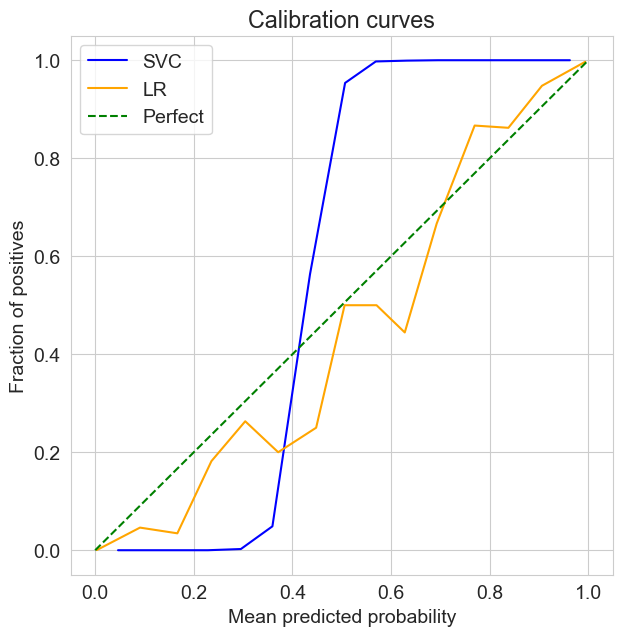

In [11]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Мы видим, что кривая для логистической регрессии неплохо приближает диагональ. То же самое, увы, нельзя сказать про SVC. Попробуем откалибровать классификаторы и построить новые кривые.

### Методы калибровки

Наиболее популярными являются два метода калибровки &mdash; калибровка Платта (сигмоидная) и изотоническая регрессия. Оба этих метода реализованы в [`sklearn`](https://scikit-learn.org/stable/modules/calibration.html#calibration).

**Калибровка Платта**

Допустим, у нас есть обученный класификатор $b(x)$, который выдает уверенность (скор) в том, что $x$ относится к положительному классу. Метод приближает вероятность положительного класса с помощью сигмоидной функции:

$$
p\big(y = +1 \big| b(x)\big) = \frac{1}{1 + \exp (A \cdot b(x) + C)}
$$

Здесь обучаемыми параметрами являются $A, C \in \mathbb{R}$, их подбирают с помощью метода максимального правдоподобия (точно так же, как в логистической регрессии). Сделать это можно по кросс-валидации или на отложенной выборке. 

**Изотоническая регрессия**

Другой метод использует так называемую изотоническую функцию &mdash; кусочно-линейную возрастающую функцию $f: \mathbb{R} \rightarrow \mathbb{R}$. Функция подбирается так, чтобы минимизировать MSE по выборке:

$$
\frac{1}{\ell} \sum_{i=1}^\ell \big(y_i - f(b(x_i))\big)^2 \rightarrow \min_f
$$

Этот метод склонен к переобучению, поэтому его рекомендуется применять только для больших выборок.

Мы будем подбирать параметры калибровки с помощью кросс-валидации. Конечно, нет большого смысла калибровать логистическую регрессию, но мы проведем небольшой эксперимент.

In [12]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.9991339493679388


In [11]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.9990994157134615


In [12]:
sigmoid_lr = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.9989797117641851


In [13]:
isotonic_lr = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = isotonic_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.9989480400147751


Построим новые калибровочные кривые:

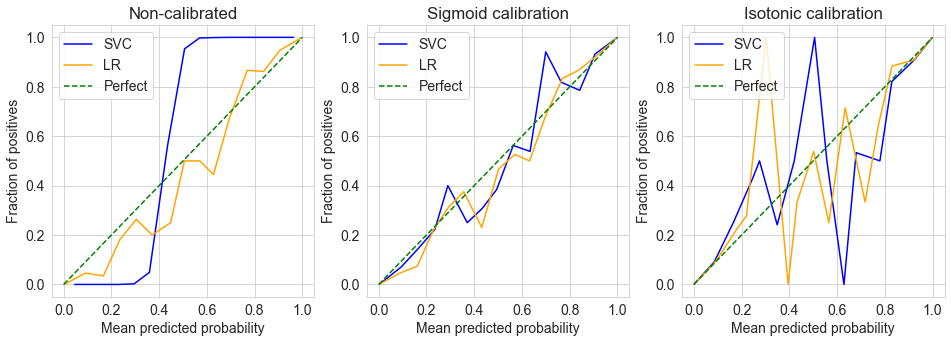

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_lr_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_lr_pred, n_bins=15)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

Как мы видим, калибровка Платта действительно улучшила вероятности, который получаются у SVC. При этом кривая для логистической регрессии практически не сдвигается. В то же время, изотоническая регрессия немного подпортила эту кривую. Судя по всему, этот метод немного переобучился, хоть у нас и есть достаточно большая выборка.